In [1]:
import numpy as np
from scipy import optimize
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import gamma
from math import pi
#pip install fbm==0.1.0
from fbm import FBM

Simulate VA by diffusing Fractional Brownian Motion

In [2]:
def evol_va(mu,sigma_a,fbm_sample,times,H):
    VA=np.exp( mu*times - ((sigma_a**2)/2)*(times**(2*H)) + sigma_a*fbm_sample)
    return(VA)

Method 1 to obtain sigma and H. Sigma is obtained from H (more potential error).

In [44]:
def find_H_sigma(VA):
    n = VA.shape[0]

    delta_t=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    frequency = []
    for d in delta_t:
        frequency.append(n // d)
    
    #resampe with different frequencies
    asset_values={}
    for f in frequency:
        fasset_values = []
        days = []
        for i in range(n):
            if i % (n // f) == 0 :
                days.append(i)
        for day in days:
            fasset_values.append(VA[day])
        asset_values[f] = fasset_values

    #calculate Variance and Mean for every frequency
    Var = []
    for i, f in enumerate(frequency):
        Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )

    Mean = []
    for i, f in enumerate(frequency):
        Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))
    var_tau = np.array(Var)


    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    fixed_intercept_log_sigma2 = np.log(var_tau[0]) # assuming delta = 1 otherwise H is here

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2


    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #print('Regression score for H is ',model.score(X, y))

    # Coefficients de la régression
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2
    sigma_A = np.sqrt(var_tau[0]) * ((int(n/delta_t[0]))**(H))
    #for i in range(len(delta_t)):
    #    print(np.sqrt(var_tau[i]) * np.sqrt(int(n/delta_t[i])))

    return sigma_A, H

Method 2. The Calculation for Sigma appears different but it is in fact the same (from Cajueiro, Daniel O. and Fajardo, José, Volatility Estimation and Option Pricing with Fractional Brownian Motion (October 27, 2005). Available at SSRN: https://ssrn.com/abstract=837765 or http://dx.doi.org/10.2139/ssrn.837765)

In [45]:
def find_H_sigma_2(VA,T):

    ###Find H

    n = VA.shape[0]

    delta_t=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    frequency = []
    for d in delta_t:
        frequency.append(n // d)
    

    #resampe with different frequencies
    asset_values={}
    for f in frequency:
        fasset_values = []
        days = []
        for i in range(n):
            if i % (n // f) == 0 :
                days.append(i)
        for day in days:
            fasset_values.append(VA[day])
        asset_values[f] = fasset_values

    #calculate Variance and Mean for every frequency
    Var = []
    for i, f in enumerate(frequency):
        Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )

    Mean = []
    for i, f in enumerate(frequency):
        Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))
    var_tau = np.array(Var)

    
    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    fixed_intercept_log_sigma2 = np.log(var_tau[0]) # assuming delta = 1 otherwise H is here

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #print('Regression score for H is ',model.score(X, y))

    # Coefficients de la régression
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2


    #Calcul Sigma
    Z=np.log(VA)

    DZ=Z[1:]-Z[:-1]
    y=((n/T)**H)*DZ

    sigma_est= np.sqrt((n/(n-1))*np.var(y))

    return sigma_est,H

Comparison

In [49]:
def sigma_error(true_sigma,mu,H,n,n_it=10, T=1):
    
    """
    exp_sigma=np.zeros(n_it)
    err_sigma=np.zeros(n_it)

    
    for i in range (n_it):
        f = FBM(n, hurst=H, length=1, method='daviesharte')
        fbm_sample = f.fbm()
        times = f.times()
        exp_sigma[i]=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[0]
        err_sigma[i]=(exp_sigma[i]-true_sigma)**2

    return (np.mean(exp_sigma),np.mean(err_sigma))
    """
    
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,true_sigma,fbm_sample,times,H)
    sigma_1=find_H_sigma(VA)[0]
    sigma_2=find_H_sigma_2(VA,T)[0]

    err1=np.abs(sigma_1-true_sigma)
    err2=np.abs(sigma_2-true_sigma)
    return(sigma_1,sigma_2,err1,err2)


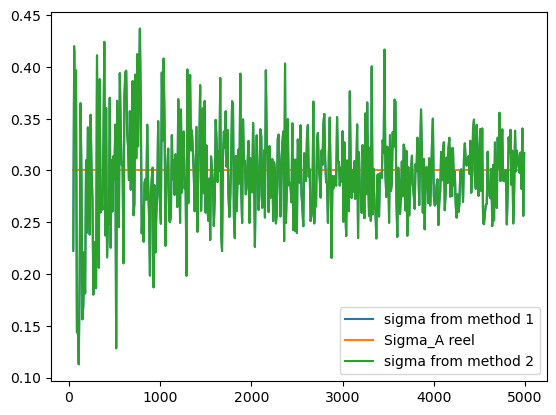

In [55]:
sigma_a=0.3
H=0.6
mu=0
T=1

sigma_1=[]
sigma_2=[]
err_sigma1=[]
err_sigma2=[]

liste_n=[]
r_s=[]

for n in range(50,5000,10):
    liste_n.append(n)
    s1,s2,e1,e2=sigma_error(sigma_a,mu,H,n,n_it=10)
    sigma_1.append(s1)
    sigma_2.append(s2)

    #err_sigma.append(e)
    r_s.append(sigma_a)


plt.plot(liste_n,sigma_1,label="sigma from method 1")
plt.plot(liste_n,r_s,label="Sigma_A reel")


plt.plot(liste_n,sigma_2,label="sigma from method 2")
plt.legend()